In [12]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.transforms import v2 as T
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

In [8]:
if torch.cuda.is_available():
    TORCH_DEVICE = 'cuda'
    GPU_COUNT = torch.cuda.device_count()
    print('Device: {}, Number of GPUs: {}'.format(TORCH_DEVICE, GPU_COUNT))
else:
    TORCH_DEVICE = 'cpu'
    GPU_COUNT = 1

In [40]:
# read config file for training the model
# will use some of the settings here
with open('Zoobot-backbone-transfer_config.json', 'r') as f:
    config = json.load(f)

In [14]:
def get_transform(train):
    transforms = []

    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))

    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))

    return T.Compose(transforms)

In [10]:
# Mask R-CNN with 3 channels
class Resnet50WithFPN(torch.nn.Module):
    def __init__(self):
        super(Resnet50WithFPN, self).__init__()

        m = torchvision.models.resnet50()

        # Extract 4 main layers (note: FRCNN needs this particular name mapping for return nodes)
        self.body = create_feature_extractor(
            m,
            return_nodes={f'layer{k}': str(v) for v, k in enumerate([1, 2, 3, 4])}
        )
        
        # Dry run to get number of channels for FPN
        inp = torch.randn(2, 3, 224, 224)
        # inp = inp.to(TORCH_DEVICE)
        
        with torch.no_grad():
            out = self.body(inp)
        in_channels_list = [o.shape[1] for o in out.values()]
        
        # Build FPN
        self.out_channels = 256
        self.fpn = FeaturePyramidNetwork(
            in_channels_list, out_channels=self.out_channels,
            extra_blocks=LastLevelMaxPool())

    def forward(self, x):
        x = self.body(x)
        x = self.fpn(x)
        return x

In [41]:
# Build the model
model = MaskRCNN(Resnet50WithFPN(), num_classes=config['num_classes'])

# checkpoint was very likely also saved in DataParallel mode
model = nn.DataParallel(model)
model.to(TORCH_DEVICE)

# load checkpoint
model.load_state_dict(torch.load(
    config['log_dir'] + config['final_model_ckpt'],
    map_location=torch.device(TORCH_DEVICE)
))

model.eval()

DataParallel(
  (module): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): Resnet50WithFPN(
      (body): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Module(
          (0): Module(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, e

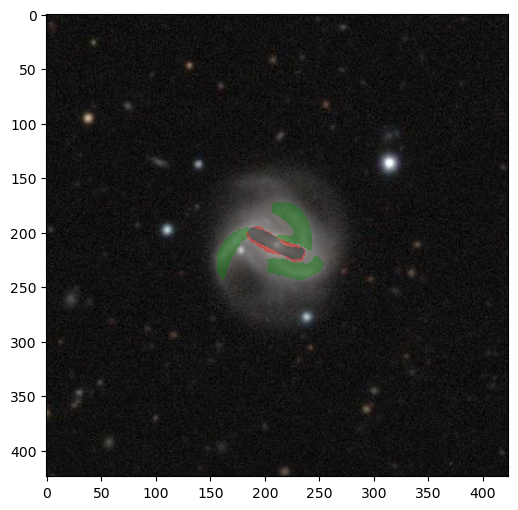

In [42]:
score_threshold = 0.3
mask_threshold = 0.7

image = read_image(config['image_dir'] + 'pngs/335470782.png')
eval_transform = get_transform(train=False)

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(TORCH_DEVICE)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()

idx = set((pred['scores'] >= score_threshold).nonzero().flatten().tolist())
idx_spiral = list(set((pred['labels'] == 1).nonzero().flatten().tolist()).intersection(idx))
idx_bar = list(set((pred['labels'] == 2).nonzero().flatten().tolist()).intersection(idx))

masks_spiral = (pred['masks'][idx_spiral] > mask_threshold).squeeze(1)
masks_bars = (pred['masks'][idx_bar] > mask_threshold).squeeze(1)

output_image = draw_segmentation_masks(image, masks_spiral, alpha=0.4, colors='green')
output_image = draw_segmentation_masks(output_image, masks_bars, alpha=0.4, colors='red') 

# output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors='red', width=1)

plt.figure(figsize=(6, 6))
plt.imshow(output_image.permute(1, 2, 0))

In [43]:
pred_labels

['2: 0.999', '1: 0.998', '2: 0.497', '2: 0.249', '1: 0.073']